## Задачи 1 и 2

In [291]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np
import math

In [90]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples = 800, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=42)

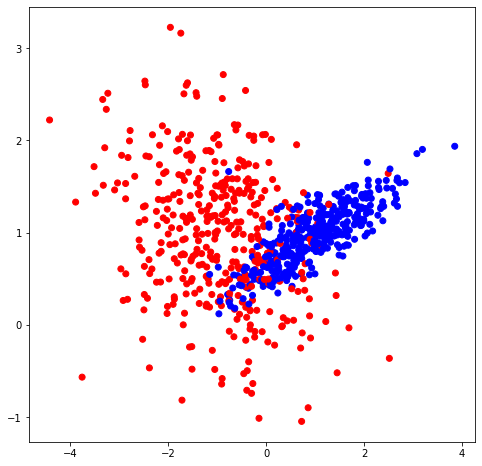

In [91]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [266]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [267]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

### Реализован расчет критерия Джени или Энтропии в зависимости от параметра cr_type

In [268]:
# Расчет критерия Джини или Энтропии

def criterion(labels, cr_type):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    if cr_type == 'gini':
        impurity = 1
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p ** 2
    else:
        impurity = 0
        for label in classes:
            p = classes[label] / len(labels)
            impurity -= p * math.log(p, 2)
        
    return impurity

In [269]:
# Расчет качества

def quality(left_labels, right_labels, current_criter, cr_type):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_criter - p * criterion(left_labels, cr_type) - (1 - p) * criterion(right_labels, cr_type)

In [270]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [277]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels, max_features, cr_type):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_criter = criterion(labels, cr_type)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in np.random.choice(range(n_features), max_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_criter, cr_type)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

### max_depth - максимальная глубина, max_features - максимальное количество признаков, max_leaves - максимальное количество листьев. Ограничение max_features используется внутри find_best_split.

In [278]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels, depth, num_leaf, max_depth, max_features, max_leaves, cr_type):
    global cur_leaf
    cur_leaf = num_leaf
    
    quality, t, index = find_best_split(data, labels, max_features, cr_type)
    
    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        cur_leaf += 1
        return Leaf(data, labels)
    
    #  Ограничение на глубину дерева
    if depth == max_depth:
        cur_leaf += 1
        return Leaf(data, labels)
    
    # Ограничение на количество листьев
    if cur_leaf + depth >= max_leaves:
        cur_leaf += 1
        return Leaf(data, labels)
 
    
    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels, depth + 1, cur_leaf, max_depth, max_features, max_leaves, cr_type)
    false_branch = build_tree(false_data, false_labels, depth + 1, cur_leaf, max_depth, max_features, max_leaves, cr_type)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [279]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [280]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [281]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [314]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, 0, 0, 5, 2, 10, 'gini')

In [315]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing, depth, num_leaf):
    global cur_leaf
    cur_leaf = num_leaf

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        cur_leaf += 1
        print(spacing + "Прогноз:", node.prediction, ' номер листа: ', cur_leaf)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:', 'depth = ' + str(depth))
    print_tree(node.true_branch, spacing + "  ", depth + 1, cur_leaf)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:', 'depth = ' + str(depth))
    print_tree(node.false_branch, spacing + "  ", depth + 1, cur_leaf)
    
print_tree(my_tree, "", 0, 0)

Индекс 0
Порог 0.032921885053392774
--> True: depth = 0
  Индекс 0
  Порог -0.7885841470667556
  --> True: depth = 1
    Индекс 1
    Порог 0.6275114748786194
    --> True: depth = 2
      Индекс 1
      Порог 0.503675584699468
      --> True: depth = 3
        Индекс 0
        Порог -0.9687133478538184
        --> True: depth = 4
          Прогноз: 0  номер листа:  1
        --> False: depth = 4
          Прогноз: 0  номер листа:  2
      --> False: depth = 3
        Прогноз: 0  номер листа:  3
    --> False: depth = 2
      Прогноз: 0  номер листа:  4
  --> False: depth = 1
    Индекс 1
    Порог 0.883593841251299
    --> True: depth = 2
      Индекс 1
      Порог 0.19228359055165611
      --> True: depth = 3
        Прогноз: 0  номер листа:  5
      --> False: depth = 3
        Индекс 1
        Порог 0.5956272432502661
        --> True: depth = 4
          Прогноз: 1  номер листа:  6
        --> False: depth = 4
          Прогноз: 0  номер листа:  7
    --> False: depth = 2
      Пр

In [316]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [317]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [318]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [319]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

91.96428571428571

In [320]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

87.5

Text(0.5, 1.0, 'Test accuracy=87.50')

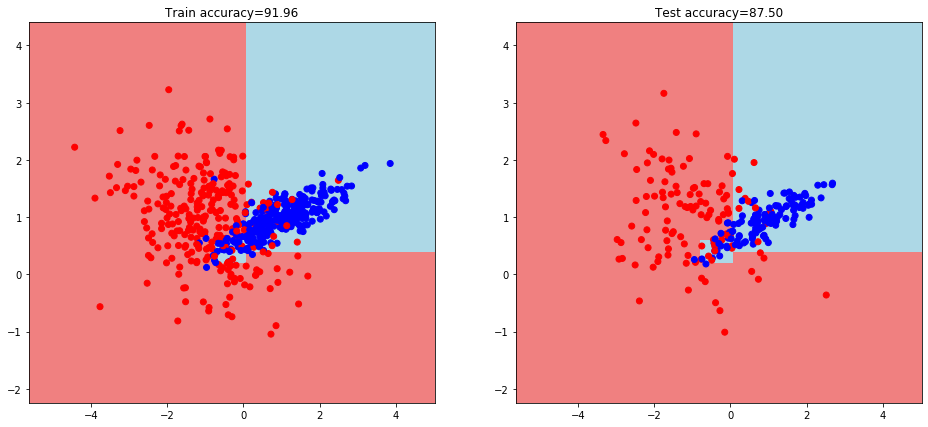

In [321]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

### Построение дерева с помощью критерия информативности Энтропии Шеннона

In [323]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels, 0, 0, 5, 2, 10, 'entr')

In [324]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing, depth, num_leaf):
    global cur_leaf
    cur_leaf = num_leaf

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        cur_leaf += 1
        print(spacing + "Прогноз:", node.prediction, ' номер листа: ', cur_leaf)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:', 'depth = ' + str(depth))
    print_tree(node.true_branch, spacing + "  ", depth + 1, cur_leaf)

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:', 'depth = ' + str(depth))
    print_tree(node.false_branch, spacing + "  ", depth + 1, cur_leaf)
    
print_tree(my_tree, "", 0, 0)

Индекс 0
Порог 0.032921885053392774
--> True: depth = 0
  Индекс 1
  Порог 0.883593841251299
  --> True: depth = 1
    Индекс 0
    Порог -1.170802772245552
    --> True: depth = 2
      Прогноз: 0  номер листа:  1
    --> False: depth = 2
      Индекс 0
      Порог -0.8222742256756725
      --> True: depth = 3
        Индекс 0
        Порог -0.9671314889434233
        --> True: depth = 4
          Прогноз: 0  номер листа:  2
        --> False: depth = 4
          Прогноз: 0  номер листа:  3
      --> False: depth = 3
        Индекс 0
        Порог -0.6636959457964142
        --> True: depth = 4
          Прогноз: 1  номер листа:  4
        --> False: depth = 4
          Прогноз: 0  номер листа:  5
  --> False: depth = 1
    Индекс 0
    Порог -0.7885841470667556
    --> True: depth = 2
      Прогноз: 0  номер листа:  6
    --> False: depth = 2
      Индекс 0
      Порог -0.6517179922445833
      --> True: depth = 3
        Прогноз: 0  номер листа:  7
      --> False: depth = 3
       

In [325]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [326]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [327]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

90.17857142857143

In [328]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

85.41666666666666

Text(0.5, 1.0, 'Test accuracy=85.42')

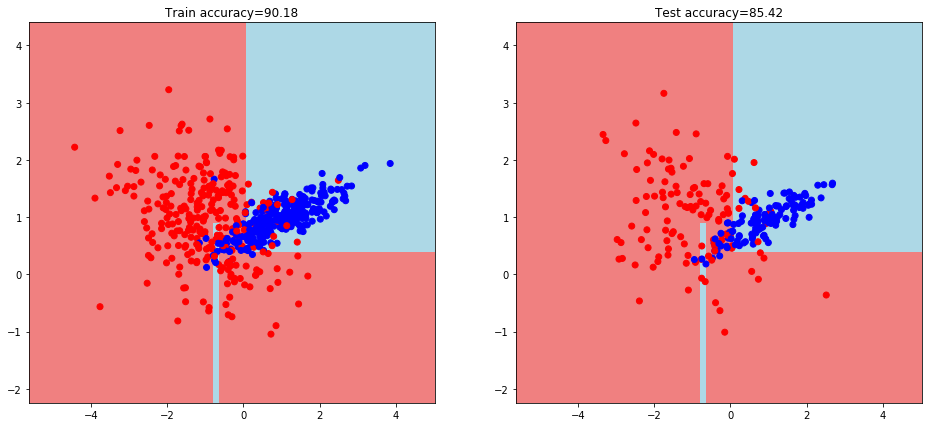

In [329]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

### В данном случае Критерий Джини дает бОльшую точность, чем критерий энтропии

### Задача 3

In [357]:
# сгенерируем данные
classification_data, classification_labels, coef = datasets.make_regression(n_samples=1000, n_features = 1, n_informative = 1, n_targets = 1, 
                                              noise = 5, coef = True, random_state = 5)

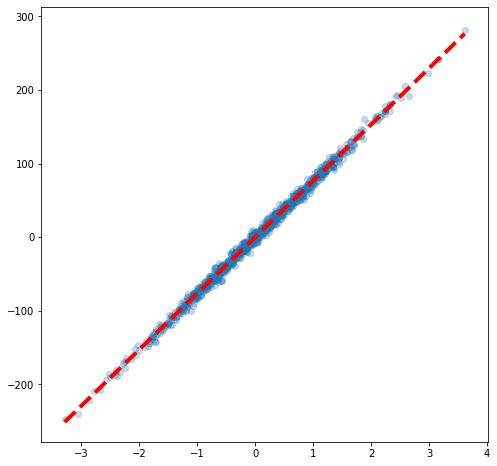

In [358]:
# визуализируем сгенерированные данные


plt.figure(figsize=(8,8))

func_y = lambda x: coef * x
x_plot = np.linspace(classification_data.min(), classification_data.max(), 1000)
y_plot = func_y(x_plot)
plt.plot(x_plot, y_plot, "r--", linewidth=4)
plt.scatter(classification_data, classification_labels, alpha=0.25)

In [359]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [371]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return np.mean(self.labels)        

In [372]:
# Расчет критерия Джини

def gini(labels):
    return np.var(labels)/len(labels)

In [373]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [374]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [375]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [376]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [377]:
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [378]:
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [379]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [380]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [381]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.10593044205742323
--> True:
  Индекс 0
  Порог -1.500859400279106
  --> True:
    Индекс 0
    Порог -2.1320856195468827
    --> True:
      Индекс 0
      Порог -2.579869018051704
      --> True:
        Прогноз: -222.26444499474928
      --> False:
        Индекс 0
        Порог -2.386697744379377
        --> True:
          Прогноз: -186.12741825400664
        --> False:
          Прогноз: -171.08945321516006
    --> False:
      Индекс 0
      Порог -1.7072739694280112
      --> True:
        Индекс 0
        Порог -1.8451851363285414
        --> True:
          Прогноз: -150.86399293754116
        --> False:
          Прогноз: -138.1693451444516
      --> False:
        Индекс 0
        Порог -1.59969850388824
        --> True:
          Прогноз: -126.99154842881447
        --> False:
          Прогноз: -120.11099923860226
  --> False:
    Индекс 0
    Порог -0.6385105554205018
    --> True:
      Индекс 0
      Порог -0.9993307344363753
      --> True:
        И

In [382]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [383]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [384]:
# реализуем функцию, определяющую среднеквадратичную ошибку
def mserror(actual, predicted):
    return (sum((actual - predicted)**2)) / len(actual)

In [385]:
# Точность на обучающей выборке
train_mserror = mserror(train_labels, train_answers)
train_mserror

60.72271255767566

In [387]:
# Точность на тестовой выборке
test_mserror = mserror(test_labels, answers)
test_mserror

59.72114772201714

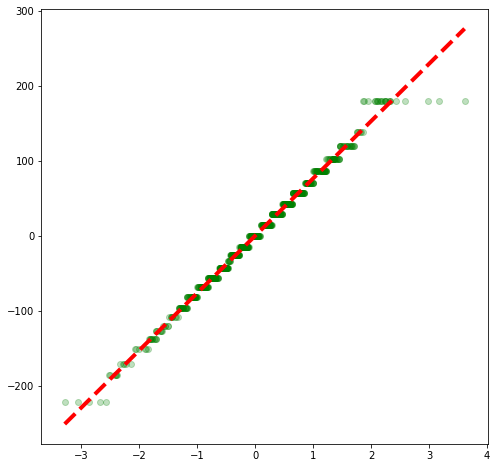

In [396]:
# визуализируем сгенерированные данные


plt.figure(figsize=(8,8))

func_y = lambda x: coef * x
x_plot = np.linspace(train_data.min(), train_data.max(), 1000)
y_plot = func_y(x_plot)
plt.plot(x_plot, y_plot, "r--", linewidth=4)
plt.scatter(train_data, train_answers, alpha=0.25, color = 'green')
#plt.scatter(train_data, train_labels, alpha=0.25)

Использовала модель с одним параметром, чтобы получить наглядную картинку. Качество модели получилось довольно низкое.